In [14]:
from dotenv import load_dotenv
load_dotenv()  # Loads from local .env by default

import os
os.environ["USER_AGENT"] = "my-langchain-app/1.0"  # Set a user agent for API requests
groq_key = os.getenv("GROQ_API_KEY")

from groq import Groq
groq_client = Groq(api_key=groq_key)

print("Groq client initialized ✅")

Groq client initialized ✅


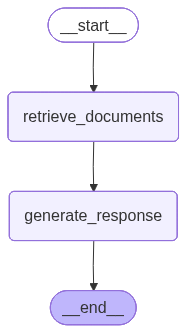

In [15]:
import nest_asyncio
import operator
from langchain.schema import Document
from langchain_core.messages import HumanMessage, AnyMessage, get_buffer_string
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import List
from typing_extensions import TypedDict, Annotated
from utils import get_vector_db_retriever, RAG_PROMPT

nest_asyncio.apply()

retriever = get_vector_db_retriever()
llm = ChatGroq(model_name="llama-3.1-8b-instant", temperature=0)

# Define Graph state
class GraphState(TypedDict):
    question: str
    messages: Annotated[List[AnyMessage], operator.add]
    documents: List[Document]

# Define Nodes
def retrieve_documents(state: GraphState):
    messages = state.get("messages", [])
    question = state["question"]
    documents = retriever.invoke(f"{get_buffer_string(messages)} {question}")
    return {"documents": documents}

def generate_response(state: GraphState):
    question = state["question"]
    messages = state["messages"]
    documents = state["documents"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    rag_prompt_formatted = RAG_PROMPT.format(context=formatted_docs, conversation=messages, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"documents": documents, "messages": [HumanMessage(question), generation]}

# Define Graph
graph_builder = StateGraph(GraphState)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "generate_response")
graph_builder.add_edge("generate_response", END)

simple_rag_graph = graph_builder.compile()
display(Image(simple_rag_graph.get_graph().draw_mermaid_png()))

In [16]:
# Creative, robust RAG graph invocation with advanced error handling and user feedback
import traceback
import socket
import httpx

def is_connected(host="8.8.8.8", port=53, timeout=3):
    """Check internet connectivity by attempting to connect to a DNS server."""
    try:
        socket.setdefaulttimeout(timeout)
        socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect((host, port))
        return True
    except Exception:
        return False

question = "How do I set up tracing if I'm using LangChain?"
if not is_connected():
    print("🚫 No internet connection. Please check your network and try again.")
else:
    try:
        print("🌐 Connected! Running the RAG graph...")
        result = simple_rag_graph.invoke({"question": question}, config={"metadata": {"foo": "bar"}})
        print("✅ Success! Here is your result:")
        print(result)
    except httpx.ConnectError as ce:
        print("❌ Connection error: Unable to reach the Groq API. Please check your internet or proxy settings.")
        print(f"Details: {ce}")
    except httpx.HTTPStatusError as he:
        print(f"❌ HTTP error: {he.response.status_code} - {he.response.text}")
    except Exception as e:
        print("❌ An unexpected error occurred:")
        traceback.print_exc()

🌐 Connected! Running the RAG graph...
✅ Success! Here is your result:
{'question': "How do I set up tracing if I'm using LangChain?", 'messages': [HumanMessage(content="How do I set up tracing if I'm using LangChain?", additional_kwargs={}, response_metadata={}), AIMessage(content='To set up tracing with LangChain, you can use the `tracing_context` context manager in Python or pass a `LangChainTracer` instance as a callback in Python or JS/TS. Additionally, you can set the `LANGSMITH_TRACING` environment variable to enable tracing for the entire application run.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 1307, 'total_tokens': 1373, 'completion_time': 0.087906377, 'prompt_time': 0.079801498, 'queue_time': 0.045785841, 'total_time': 0.167707875}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_3ddc9808b3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--4eb943a8-8383-4c94-8316-0495

In [17]:
from langsmith import traceable, trace
from groq import Groq
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "groq"
MODEL_NAME = "llama-3.1-8b-instant"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

groq_client = Groq()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

"""
retrieve_documents
- Returns documents fetched from a vectorstore based on the user's question
"""
@traceable
def retrieve_documents(question: str):
    documents = retriever.invoke(question)
    return documents

"""
generate_response
- Calls `call_groq` to generate a model response after formatting inputs
"""
# TODO: Remove traceable, and use with trace()
@traceable
def generate_response(question: str, documents):
    # NOTE: Our documents came in as a list of objects, but we just want to log a string
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)

    # TODO: Use with trace()
    # with trace(
    #     name="Generate Response",
    #     run_type="chain", 
    #     inputs={"question": question, "formatted_docs": formatted_docs},
    #     metadata={"foo": "bar"},
    # ) as ls_trace:
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    response = call_groq(messages)
    # TODO: End your trace and write outputs to LangSmith
    # ls_trace.end(outputs={"output": response})
    return response

"""
call_groq
- Returns the chat completion output from Groq
"""
@traceable
def call_groq(
    messages: List[dict], model: str = MODEL_NAME, temperature: float = 0.0
) -> str:
    response = groq_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )
    return response

"""
langsmith_rag
- Calls `retrieve_documents` to fetch documents
- Calls `generate_response` to generate a response based on the fetched documents
- Returns the model response
"""
@traceable
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


In [18]:
# Run langsmith_rag and print the answer with error handling
import traceback

question = "How do I trace with tracing context?"
try:
    ai_answer = langsmith_rag(question)
    print(ai_answer)
except Exception as e:
    print(f"Error: {e}")
    traceback.print_exc()

You can use the tracing_context context manager in Python to trace specific invocations. This is done by wrapping the code you want to trace with the context manager, like this: 

```python
import langsmith as ls

with ls.tracing_context(enabled=True):
    chain.invoke({"question": "Am I using a callback?", "context": "I'm using a callback"})
```

This will trace the execution of the specified code.


In [19]:
# TODO: Import wrap_groq (if available in your tracing library)
# from langsmith.wrappers import wrap_groq
from groq import Groq
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "groq"
MODEL_NAME = "llama-3.1-8b-instant"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

# TODO: Wrap the Groq Client (if needed)
groq_client = Groq()

nest_asyncio.apply()
retriever = get_vector_db_retriever()

@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    # TODO: We don't need to use @traceable on a nested function call anymore,
    # wrap_groq takes care of this for us (if available)
    return call_groq(messages)

@traceable
def call_groq(
    messages: List[dict],
) -> str:
    return groq_client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
    )

@traceable(run_type="chain")
def langsmith_rag_with_wrap_groq(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


In [20]:
# Run langsmith_rag_with_wrap_groq and print the answer with error handling
import traceback

question = "How do I trace with wrap_groq?"
try:
    ai_answer = langsmith_rag_with_wrap_groq(question)
    print(ai_answer)
except Exception as e:
    print(f"Error: {e}")
    traceback.print_exc()

I don't know. The provided context only mentions `wrap_openai` and `wrapOpenAI` for tracing with OpenTelemetry. There's no information on `wrap_groq`.


In [21]:
# Minimal, robust Groq API call with error handling
import traceback

messages = [
    {
        "role": "user",
        "content": "What color is the sky?"
    }
]

try:
    response = groq_client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages
    )
    print(response)
except Exception as e:
    print(f"Error: {e}")
    traceback.print_exc()

ChatCompletion(id='chatcmpl-507268ac-fd21-48d2-9da2-af11c0ff1086', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="The color of the sky can appear different depending on the time of day, atmospheric conditions, and other factors. \n\n1. During daytime: The typical blue color of the sky is due to a phenomenon called Rayleigh scattering. When sunlight enters the Earth's atmosphere, it encounters tiny molecules of gases, such as nitrogen and oxygen. These molecules scatter the shorter wavelengths of light (like blue and violet) more than the longer wavelengths (like red and orange). As a result, the sky appears blue to our eyes.\n\n2. During sunrise and sunset: The sky can take on hues of red, orange, and pink due to a different atmospheric effect. When the sun is low on the horizon, its light has to travel through a thicker layer of the atmosphere to reach our eyes. This longer path causes the light to be scattered in a way that favors

In [22]:
# No need to set API keys here. They are loaded from .env automatically by dotenv in the first code cell.
# If you need to override, edit your .env file or set os.environ before importing clients.

In [23]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env", override=True)

False

In [24]:
import os
os.environ["LANGSMITH_TRACING"] = "false"

from langsmith import utils
utils.tracing_is_enabled() # This should return false

True

In [25]:
# RunTree-based RAG pipeline with error handling
import traceback

from langsmith import RunTree
from groq import Groq
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

groq_client = Groq()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

def retrieve_documents(parent_run: RunTree, question: str):
    try:
        child_run = parent_run.create_child(
            name="Retrieve Documents",
            run_type="retriever",
            inputs={"question": question},
        )
        documents = retriever.invoke(question)
        child_run.end(outputs={"documents": documents})
        child_run.post()
        return documents
    except Exception as e:
        print(f"Error in retrieve_documents: {e}")
        traceback.print_exc()
        return []

def generate_response(parent_run: RunTree, question: str, documents):
    try:
        formatted_docs = "\n\n".join(doc.page_content for doc in documents)
        rag_system_prompt = """You are an assistant for question-answering tasks. 
        Use the following pieces of retrieved context to answer the latest question in the conversation. 
        If you don't know the answer, just say that you don't know. 
        Use three sentences maximum and keep the answer concise.
        """
        child_run = parent_run.create_child(
            name="Generate Response",
            run_type="chain",
            inputs={"question": question, "documents": documents},
        )
        messages = [
            {
                "role": "system",
                "content": rag_system_prompt
            },
            {
                "role": "user",
                "content": f"Context: {formatted_docs} \n\n Question: {question}"
            }
        ]
        groq_response = call_groq(child_run, messages)
        child_run.end(outputs={"groq_response": groq_response})
        child_run.post()
        return groq_response
    except Exception as e:
        print(f"Error in generate_response: {e}")
        traceback.print_exc()
        return None

def call_groq(parent_run: RunTree, messages: List[dict], model: str = "llama-3.1-8b-instant", temperature: float = 0.0):
    try:
        child_run = parent_run.create_child(
            name="Groq Call",
            run_type="llm",
            inputs={"messages": messages},
        )
        groq_response = groq_client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=temperature,
        )
        child_run.end(outputs={"groq_response": groq_response})
        child_run.post()
        return groq_response
    except Exception as e:
        print(f"Error in call_groq: {e}")
        traceback.print_exc()
        return None

def langsmith_rag(question: str):
    try:
        root_run_tree = RunTree(
            name="Chat Pipeline",
            run_type="chain",
            inputs={"question": question}
        )
        documents = retrieve_documents(root_run_tree, question)
        response = generate_response(root_run_tree, question, documents)
        output = response.choices[0].message.content if response else None
        root_run_tree.end(outputs={"generation": output})
        root_run_tree.post()
        return output
    except Exception as e:
        print(f"Error in langsmith_rag: {e}")
        traceback.print_exc()
        return None

In [26]:
question = "How can I trace with RunTree?"
ai_answer = langsmith_rag(question)
print(ai_answer)

You can convert LangChain's RunnableConfig to a RunTree object by using RunTree.fromRunnableConfig or pass the RunnableConfig as the first argument of the traceable-wrapped function.
